# **IMAGE CLASSIFICATION**
# **Classification of Natural Scenes around the world**

In this notebook we will use Convolutional Neural Networks to perform single-label multi-class classification. The dataset contains train, test and prediction images for 6 classes
- buildings
- forest
- glacier
- mountain
- sea
- street



### **Import all the required packages**

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras import models, layers, optimizers
import matplotlib.image as mpimg
import math
import os
import warnings
warnings.filterwarnings('ignore')

### **Setting directory paths and initializing parameters**

In [31]:
BASE_DIR = '../input/intel-image-classification'
TRAIN_DIR = os.path.join(BASE_DIR, 'seg_train/seg_train')
TEST_DIR = os.path.join(BASE_DIR, 'seg_test/seg_test')
BATCH_SIZE = 32
EPOCHS = 20

#ImageDataGenerator for training data
TRAIN_DATAGEN = ImageDataGenerator(
                rescale = 1.0/255,
                validation_split = 0.2
                )

#ImageDataGenerator for testing data
TEST_DATAGEN = ImageDataGenerator(
                rescale = 1.0/255
                )

### **Displaying Images of each class**

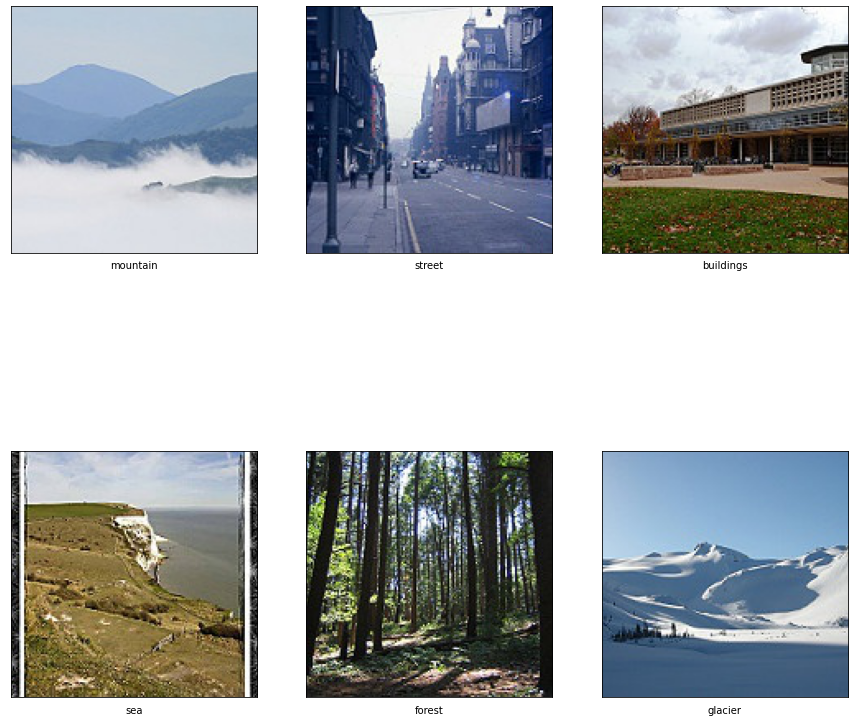

In [32]:
j=0
fig=plt.figure(figsize=(15, 15))
for i in os.listdir(TRAIN_DIR):
        img = mpimg.imread(TRAIN_DIR+"/"+i+"/"+os.listdir(TRAIN_DIR+"/"+i)[0])
        fig.add_subplot(2,3,j+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(img, cmap=plt.cm.binary)
        plt.xlabel(i)
        j += 1
plt.show()

### **Image distribution of each class in training and test set**

In [33]:
print("TRAINING DATA:")
for i in os.listdir(TRAIN_DIR):
    files = os.listdir(TRAIN_DIR+"/"+i)
    print(f'{i} : {len(files)} files')
    
print("\n\nTEST DATA:")
for i in os.listdir(TEST_DIR):
    files = os.listdir(TEST_DIR+"/"+i)
    print(f'{i} : {len(files)} files')

TRAINING DATA:
mountain : 2512 files
street : 2382 files
buildings : 2191 files
sea : 2274 files
forest : 2271 files
glacier : 2404 files


TEST DATA:
mountain : 525 files
street : 501 files
buildings : 437 files
sea : 510 files
forest : 474 files
glacier : 553 files


Almost same number of samples for each class, hence **no class-imbalance** problem.

On an average, for every class we have 2300 images in training data, which is less. If we build a convnet from scratch, there are high chances that it will overfit the training data. We can use pretrained network to deal with this.

A pretrained network is a saved network that was previously trained on a large dataset, typically on large-scale image classification task. If the original dataset is large enough and general enough, then the spatial hierarchy of features learned by the network can effectively act as a generic model of the visual world and hence it's features can be useful for many different image classification tasks.

We will use pretrained **VGG16 model**. This model was trained on ImageNet dataset for 1000 classes. Features learned by the initial layers of VGG16 model are generic enough to apply for other image classification tasks.

Let's go with feature extraction using pretrained VGG16 model.


# **VGG16 Architecture**

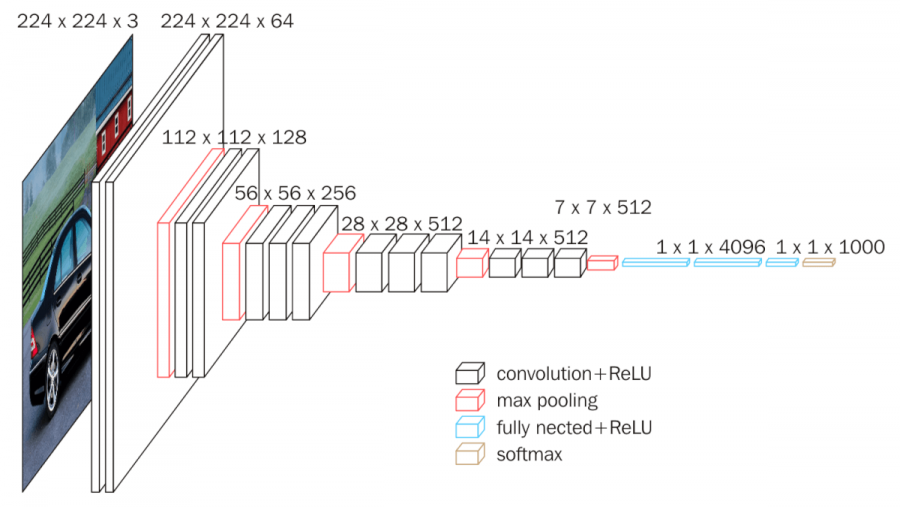

We will be using VGG16 model pretrained on ImageNet dataset.

The input to any of the network configurations is considered to be a fixed size 224 x 224 image with three channels – R, G, and B. The only pre-processing done is normalizing the RGB values for every pixel. This is achieved by subtracting the mean value from every pixel. 

Image is passed through the first stack of 2 convolution layers of the very small receptive size of 3 x 3, followed by ReLU activations. Each of these two layers contains 64 filters. The convolution stride is fixed at 1 pixel, and the padding is 1 pixel. This configuration preserves the spatial resolution, and the size of the output activation map is the same as the input image dimensions. The activation maps are then passed through spatial max pooling over a 2 x 2-pixel window, with a stride of 2 pixels. This halves the size of the activations. Thus the size of the activations at the end of the first stack is 112 x 112 x 64. 

The activations then flow through a similar second stack, but with 128 filters as against 64 in the first one. Consequently, the size after the second stack becomes 56 x 56 x 128. This is followed by the third stack with three convolutional layers and a max pool layer. The no. of filters applied here are 256, making the output size of the stack 28 x 28 x 256. This is followed by two stacks of three convolutional layers, with each containing 512 filters. The output at the end of both these stacks will be 7 x 7 x 512.

The stacks of convolutional layers are followed by three fully connected layers with a flattening layer in-between. The first two have 4,096 neurons each, and the last fully connected layer serves as the output layer and has 1,000 neurons corresponding to the 1,000 possible classes for the ImageNet dataset. The output layer is followed by the Softmax activation layer used for categorical classification.

### **Preparing Data**

In [34]:
train_generator = TRAIN_DATAGEN.flow_from_directory(
                    TRAIN_DIR,
                    target_size = (150,150),
                    batch_size = BATCH_SIZE,
                    class_mode = 'categorical',
                    subset='training'
                  )

validation_generator = TRAIN_DATAGEN.flow_from_directory(
                    TRAIN_DIR,
                    target_size = (150,150),
                    batch_size = BATCH_SIZE,
                    class_mode = 'categorical',
                    subset='validation'
                  )

test_generator = TEST_DATAGEN.flow_from_directory(
                    TEST_DIR,
                    target_size = (150,150),
                    batch_size = BATCH_SIZE,
                    class_mode = 'categorical'
                  )

Found 11230 images belonging to 6 classes.
Found 2804 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


Load the VGG16 model's **convolutional base**.

parameter include_top=False lets us **drop the trained classifier** from VGG16 model.

### Loading VGG16 Model and freezing all its layer

In [35]:
conv_base = VGG16(
                    weights = 'imagenet',
                    include_top = False,
                    input_shape = (150,150,3)
                 )

In [36]:
set_trainable = False
for layer in conv_base.layers:
    layer.trainable = False

In [37]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

### Defining our model with it's own classifier on top of VGG16 convolutional base.

In [38]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(6, activation='softmax'))

In [39]:
model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(lr=2e-5), metrics=['acc'])

In [40]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 1542      
Total params: 16,813,638
Trainable params: 2,098,950
Non-trainable params: 14,714,688
_________________________________________________________________


In [41]:
history = model.fit_generator(
                                train_generator,
                                steps_per_epoch = train_generator.samples // BATCH_SIZE,
                                epochs = EPOCHS,
                                validation_data = validation_generator,
                                validation_steps = validation_generator.samples // BATCH_SIZE,
                             )

2022-09-12 17:14:06.815653: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20


2022-09-12 17:14:08.412471: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


350/350 [==============================] - 87s 226ms/step - loss: 1.0729 - acc: 0.6003 - val_loss: 0.5749 - val_acc: 0.8197
Epoch 2/20
350/350 [==============================] - 24s 67ms/step - loss: 0.5690 - acc: 0.7989 - val_loss: 0.4576 - val_acc: 0.8434
Epoch 3/20
350/350 [==============================] - 25s 72ms/step - loss: 0.4807 - acc: 0.8269 - val_loss: 0.4149 - val_acc: 0.8581
Epoch 4/20
350/350 [==============================] - 24s 69ms/step - loss: 0.4347 - acc: 0.8460 - val_loss: 0.3892 - val_acc: 0.8646
Epoch 5/20
350/350 [==============================] - 24s 69ms/step - loss: 0.4008 - acc: 0.8570 - val_loss: 0.3743 - val_acc: 0.8732
Epoch 6/20
350/350 [==============================] - 25s 70ms/step - loss: 0.3765 - acc: 0.8648 - val_loss: 0.3649 - val_acc: 0.8664
Epoch 7/20
350/350 [==============================] - 24s 69ms/step - loss: 0.3528 - acc: 0.8768 - val_loss: 0.3599 - val_acc: 0.8667
Epoch 8/20
350/350 [==============================] - 25s 70ms/step - lo

In [42]:
def plot_acc_loss(history):

    train_acc = history.history['acc']
    val_acc = history.history['val_acc']
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(train_acc)+1)

    plt.plot(epochs, train_acc, label='Training accuracy')
    plt.plot(epochs, val_acc, label='Validation accuracy', color='red')
    plt.title("Training and Validation Accuracy")
    plt.legend()
    plt.figure()

    plt.plot(epochs, train_loss, label='Training loss')
    plt.plot(epochs, val_loss, label='Validation loss', color='red')
    plt.title("Training and Validation loss")
    plt.legend()
    plt.show()
    print("Average Validation loss: ", np.mean(val_loss))
    print(f"Average Validation accuracy: {np.mean(val_acc)*100:.2f} %")

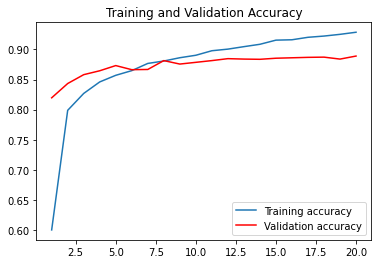

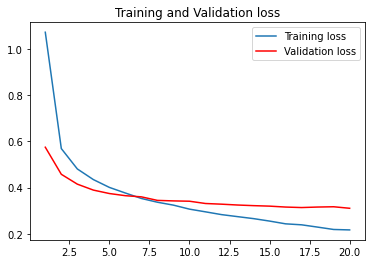

Average Validation loss:  0.3580468326807022
Average Validation accuracy: 87.40 %


In [43]:
plot_acc_loss(history)

### Testset Accuracy before fine-tuning

In [44]:
test_loss, test_acc = model.evaluate_generator(test_generator, steps=test_generator.samples // BATCH_SIZE)
print(f"Test Accuracy before fine tuning: {test_acc*100:.2f} %")

Test Accuracy before fine tuning: 88.37 %


## **Fine Tuning**

Let's push the performance a bit further by **fine-tuning** the VGG16 model.

In fine-tuning we slightly adjust the more abstract representations of the model being reused, in order to make them more relevant to the problem at hand. We are going to unfreeze last block convolution layers of the model. To limit the magnitude of modification made to pretrained representations, let's keep small learning rate.

In [45]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name=='block5_conv1':
        set_trainable = True
    if set_trainable == True:
        layer.trainable = True
    else:
        layer.trainable = False

In [46]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [47]:
model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(lr=1e-5), metrics=['acc'])
history = model.fit_generator(
                                train_generator,
                                steps_per_epoch = train_generator.samples // BATCH_SIZE,
                                epochs = EPOCHS,
                                validation_data = validation_generator,
                                validation_steps = validation_generator.samples // BATCH_SIZE,
                             )

Epoch 1/20
350/350 [==============================] - 26s 71ms/step - loss: 0.1982 - acc: 0.9300 - val_loss: 0.3148 - val_acc: 0.8879
Epoch 2/20
350/350 [==============================] - 25s 71ms/step - loss: 0.1400 - acc: 0.9506 - val_loss: 0.2953 - val_acc: 0.9016
Epoch 3/20
350/350 [==============================] - 25s 72ms/step - loss: 0.1092 - acc: 0.9637 - val_loss: 0.3178 - val_acc: 0.8883
Epoch 4/20
350/350 [==============================] - 25s 70ms/step - loss: 0.0845 - acc: 0.9734 - val_loss: 0.2929 - val_acc: 0.9084
Epoch 5/20
350/350 [==============================] - 25s 72ms/step - loss: 0.0626 - acc: 0.9819 - val_loss: 0.2886 - val_acc: 0.9037
Epoch 6/20
350/350 [==============================] - 25s 72ms/step - loss: 0.0524 - acc: 0.9845 - val_loss: 0.2930 - val_acc: 0.9098
Epoch 7/20
350/350 [==============================] - 25s 71ms/step - loss: 0.0432 - acc: 0.9873 - val_loss: 0.2963 - val_acc: 0.9106
Epoch 8/20
350/350 [==============================] - 25s 71ms

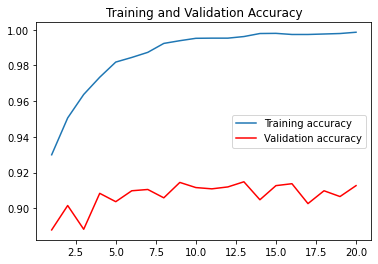

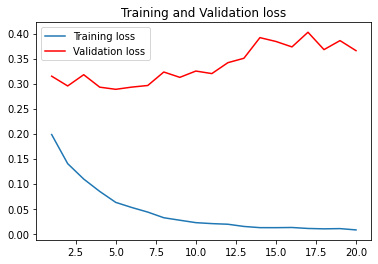

Average Validation loss:  0.3371961161494255
Average Validation accuracy: 90.72 %


In [48]:
plot_acc_loss(history)

### Testset Accuracy after fine-tuning

In [49]:
test_loss, test_acc = model.evaluate_generator(test_generator, steps=test_generator.samples // BATCH_SIZE)
print(f"Test Accuracy after fine tuning: {test_acc*100:.2f} %")

Test Accuracy after fine tuning: 91.03 %
